In [254]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import  matmul
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from math import acos
%matplotlib inline

# 1

cpu


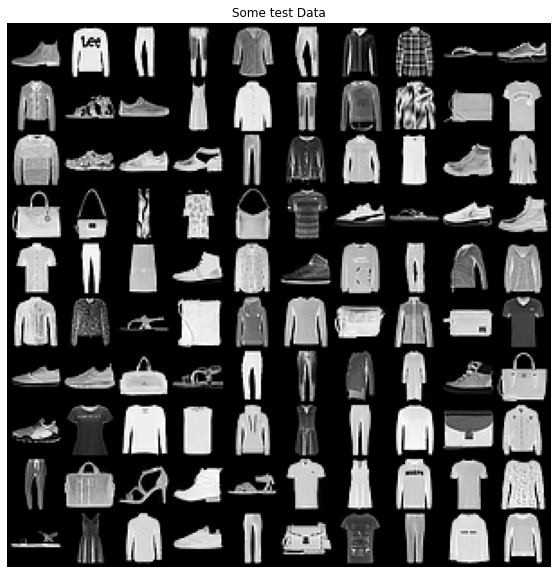

In [255]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

batch_size = 100
test_data = FashionMNIST("./data", train = False, download = True,
                          transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

train_data = FashionMNIST("./data", train = True, download = True,
                          transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)

width = 28
height = 28
input_size = width * height

def plot_images(batch, rows, cols, title = ""):
    plt.figure(figsize = (rows, cols))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(
        vutils.make_grid(batch[:(rows * cols)], nrow = rows, normalize = True).cpu(),
        (1, 2, 0)))

first_batch = next(iter(test_loader))
plot_images(first_batch[0], 10, 10, "Some test Data")

In [256]:
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self, out_size):
        super(FullyConnectedAutoencoder, self).__init__()
        self.elayer1 = nn.Linear(input_size, 256)
        self.ebatch1 = nn.BatchNorm1d(256)
        self.elayer2 = nn.Linear(256, 128)
        self.ebatch2 = nn.BatchNorm1d(128)
        self.elayer3 = nn.Linear(128, out_size)

        self.dlayer1 = nn.Linear(out_size, 128)
        self.dbatch1 = nn.BatchNorm1d(128)
        self.dlayer2 = nn.Linear(128, 256)
        self.dbatch2 = nn.BatchNorm1d(256)
        self.dlayer3 = nn.Linear(256, input_size)

    def encoder(self, x):
        y1 = F.elu(self.ebatch1(self.elayer1(x)))
        y2 = F.elu(self.ebatch2(self.elayer2(y1)))
        z = F.elu(self.elayer3(y2))
        return z

    def decoder(self, z):
        y1 = F.elu(self.dbatch1(self.dlayer1(z)))
        y2 = F.elu(self.dbatch2(self.dlayer2(y1)))
        x = torch.sigmoid(self.dlayer3(y2))
        return x

    def forward(self, x):
        x = x.view(-1, input_size)
        z = self.encoder(x)
        y = self.decoder(z)
        y = y.view(-1, 1, width, height)
        return y

class ConvolutionalAutoencoder(nn.Module):
    def __init__(self, out_size):
        super(ConvolutionalAutoencoder, self).__init__()
        self.econv1 = nn.Conv2d(1, 32, kernel_size = 5, bias = False)
        self.ebatch1 = nn.BatchNorm2d(32)
        self.econv2 = nn.Conv2d(32, 8, kernel_size = 5, bias = False)
        self.ebatch2 = nn.BatchNorm2d(8)
        self.econv3 = nn.Conv2d(8, out_size, kernel_size = 20, bias = True)

        self.dconv1 = nn.ConvTranspose2d(out_size, 8, kernel_size = 20, bias = True)
        self.dbatch1 = nn.BatchNorm2d(8)
        self.dconv2 = nn.ConvTranspose2d(8, 32, kernel_size = 5, bias = False)
        self.dbatch2 = nn.BatchNorm2d(32)
        self.dconv3 = nn.ConvTranspose2d(32, 1, kernel_size = 5, bias = False)

    def encoder(self, x):
        y1 = F.elu(self.ebatch1(self.econv1(x)))
        y2 = F.elu(self.ebatch2(self.econv2(y1)))
        z = F.elu(self.econv3(y2))
        return z


    def decoder(self, z):
        y1 = F.elu(self.dbatch1(self.dconv1(z)))
        y2 = F.elu(self.dbatch2(self.dconv2(y1)))
        x = torch.sigmoid(self.dconv3(y2))
        return x

    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y

In [257]:
def showImage(w1,w2,title1,title2):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,20))
    ax1.title.set_text(title1)
    ax1.imshow(np.transpose(
        vutils.make_grid(w1, nrow = 10, normalize = True).cpu(),
        (1, 2, 0)))
    ax2.title.set_text(title2)
    ax2.imshow(np.transpose(
        vutils.make_grid(w2, nrow = 10, normalize = True).cpu(),
        (1, 2, 0)))
    for ax in fig.get_axes():
        ax.axis("off")

    return

--------------

# 2

In [258]:
allModels = {}

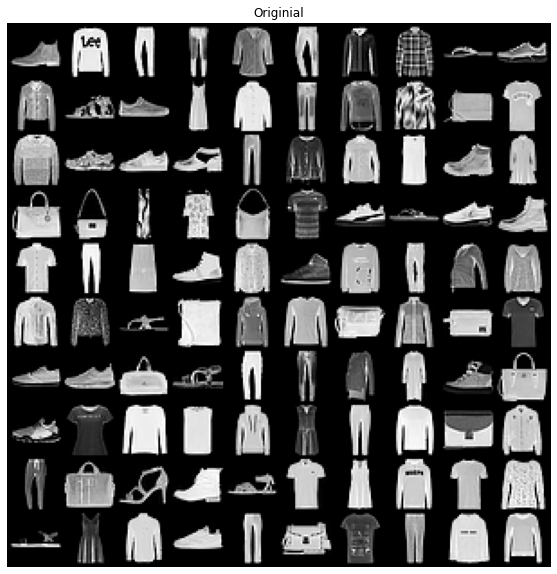

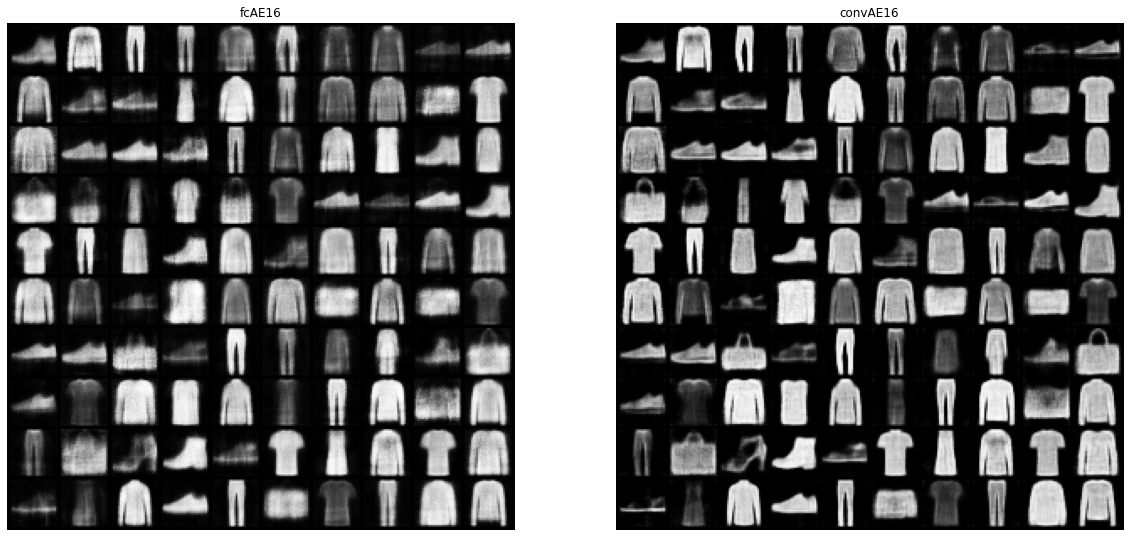

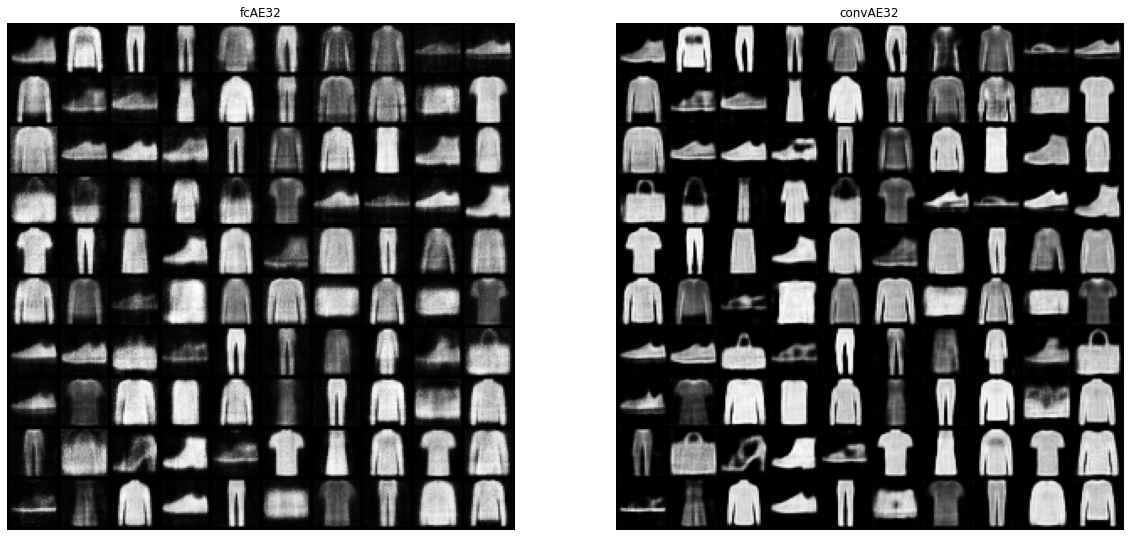

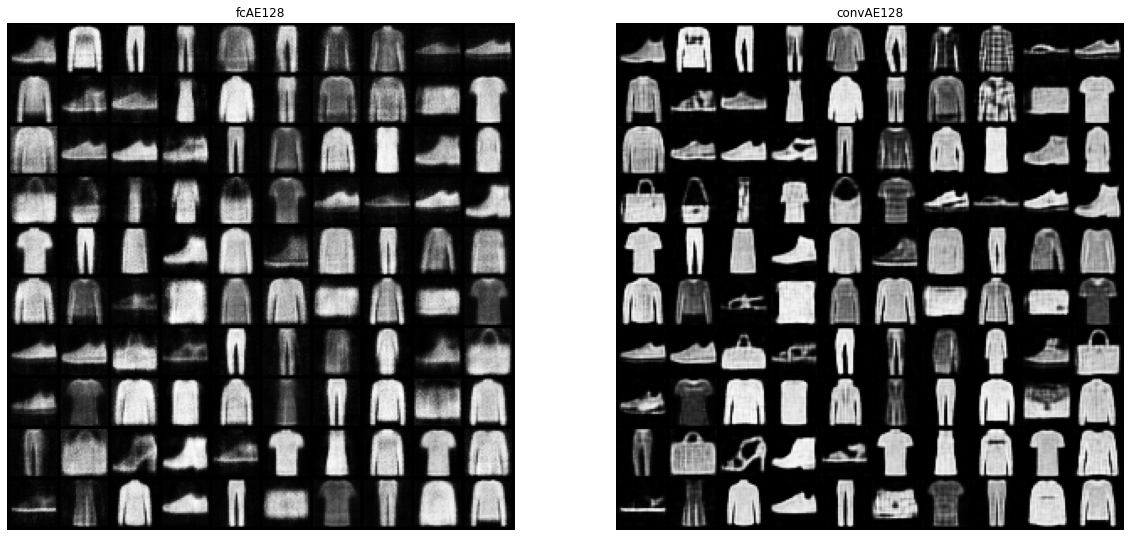

In [259]:

first_batch = next(iter(test_loader))
x = first_batch[0]
x = x.to(device)

plt.figure(figsize = (10,10))
plt.axis("off")
plt.title("Originial")
plt.imshow(np.transpose(
    vutils.make_grid(x, nrow = 10, normalize = True).cpu(),
    (1, 2, 0)))



types = ["convAE","fcAE"]
size = ["16","32","128"]
##Iterate over all the files, import models and save the model
## Generate the forwarded grid for each model
for b in size:
    n = int(b)
    model1 = FullyConnectedAutoencoder(n)
    model2 = ConvolutionalAutoencoder(n)
    model1.load_state_dict(torch.load(types[1] + b + ".pth",map_location=torch.device('cpu')))
    model2.load_state_dict(torch.load(types[0] + b + ".pth",map_location=torch.device('cpu')))
    ##True, False is a flag whether that is Fully Connected or not which is need for encoding purpose
    allModels[types[1] + b] = (True, n, model1)
    allModels[types[0] + b] = (False, n, model2)
    y1 = model1.forward(x)
    y2 = model2.forward(x)
    showImage(y1,y2,types[1] + b, types[0] + b)
model1 = ConvolutionalAutoencoder(32)
model1.load_state_dict(torch.load("convAE32_aug.pth",map_location=torch.device('cpu')))
allModels["convAE32_aug"] = (False, 32, model1)
y1 = model1.forward(x)

Answer: When the dimension of the model increases, the blurriness reduces and image get more sharpened, that is because latent space have higher variables to describe the images.
Compared to fully connected models, convolutional models are more sharp and clear.

-----------------------
# 3

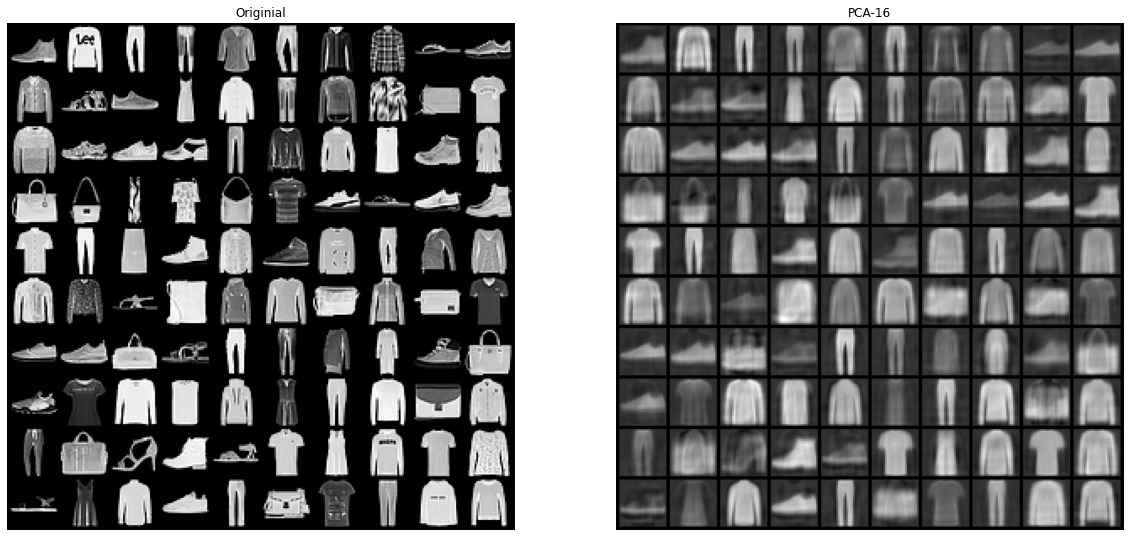

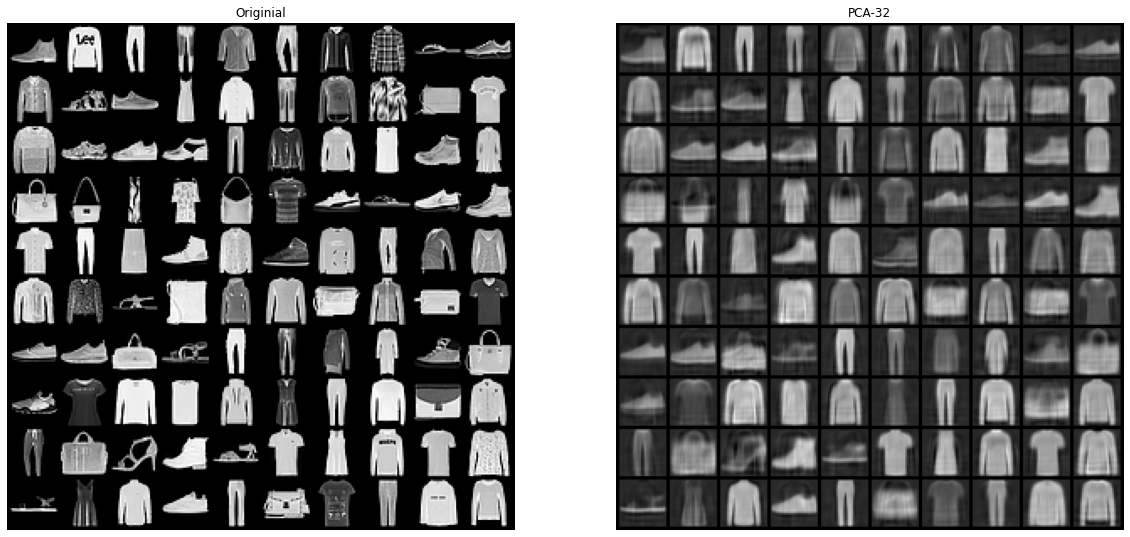

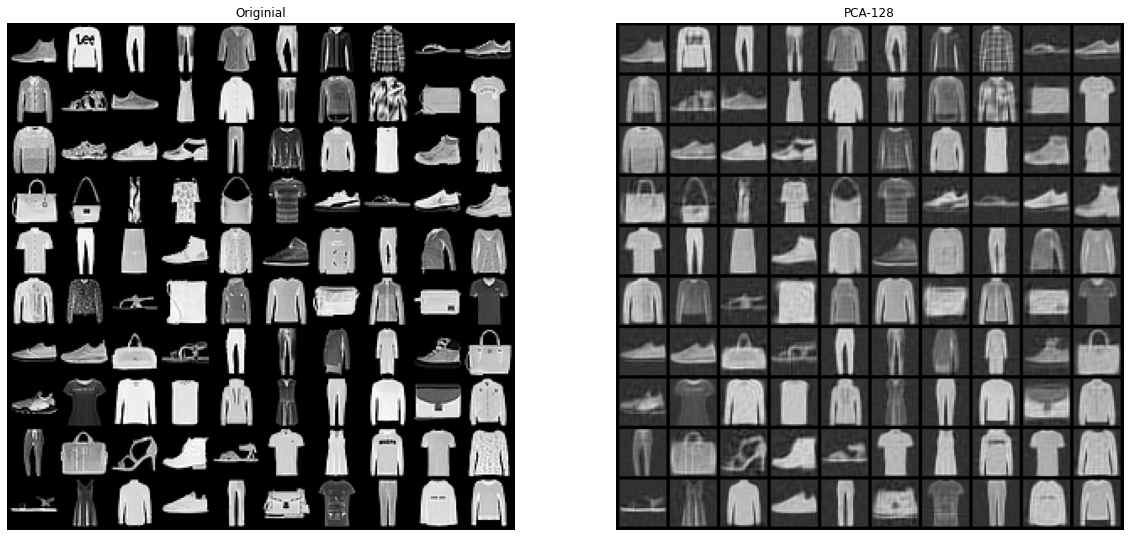

In [260]:
j = []
for i, (v, label) in enumerate(train_loader):
    j.append(v)
a = torch.cat(j)
n = len(a)

a = a.reshape(n,28*28)

b = x.reshape(100,28*28)
allPCA = {}

for i in size:
    n = int(i)
    pca = PCA(n_components=n)
    pca.fit(a)
    allPCA[i] = pca
    x_pca = pca.transform(b)
    final = pca.inverse_transform(x_pca)
    final = torch.from_numpy(final.reshape(100,1,28,28))
    showImage(x,final, "Originial", "PCA-"+i)


Answer: If we compared same dimensions (same number of principal components to the reconstruction vs auto encoders with same dimensions) the reconstructions from principal components have a lesser quality
PCA features are totally linearly uncorrelated with each other since features are projections onto the orthogonal basis. But autoencoded features might have correlations since they are just trained for accurate reconstruction.

-------------------------
# 4

In [261]:
x = x.reshape(100,1,height,width)

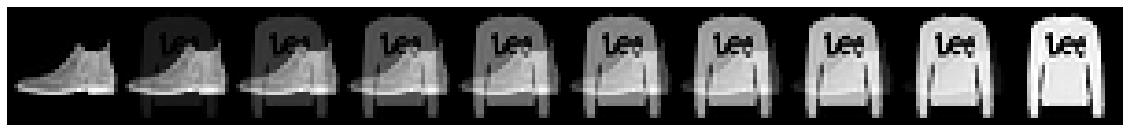

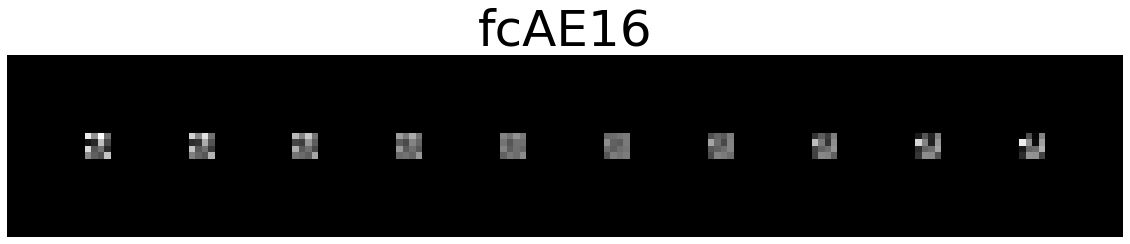

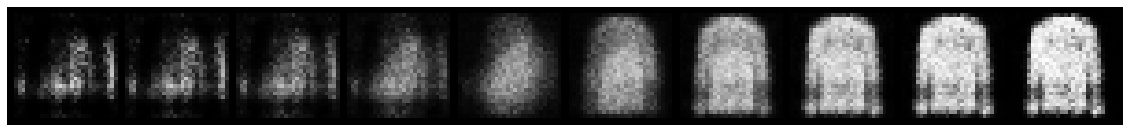

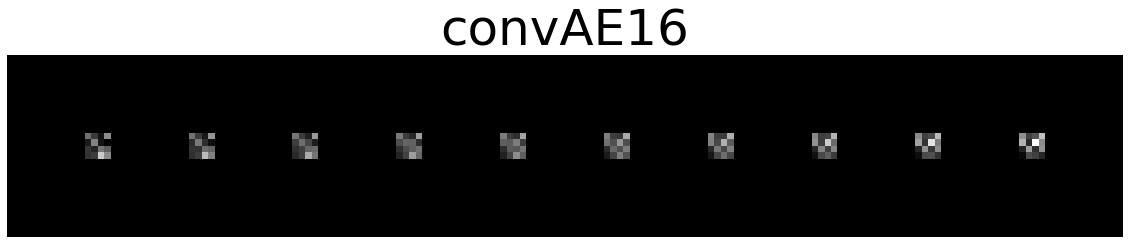

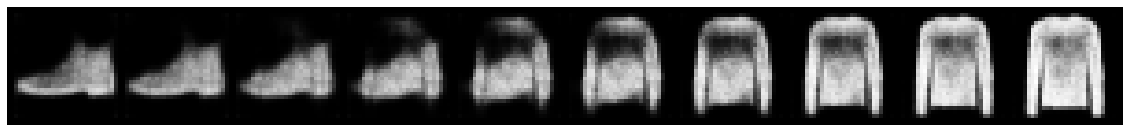

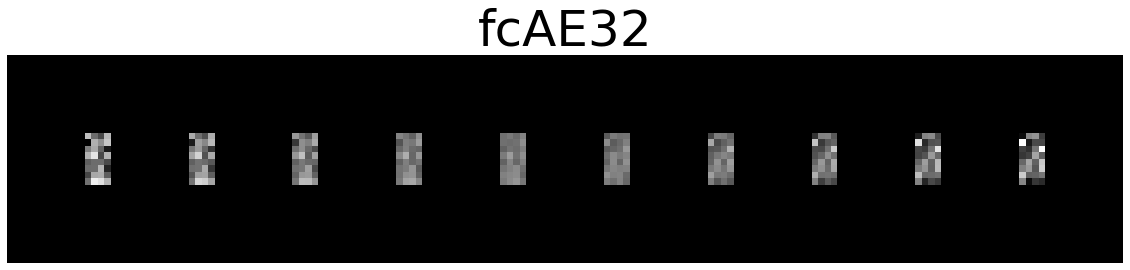

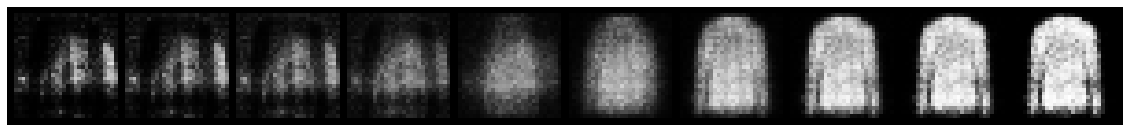

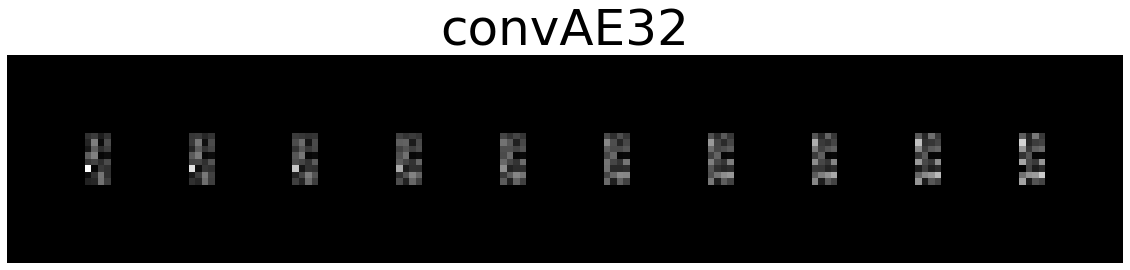

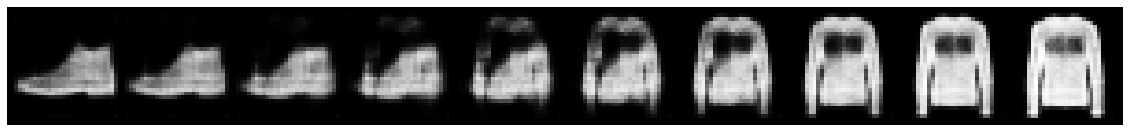

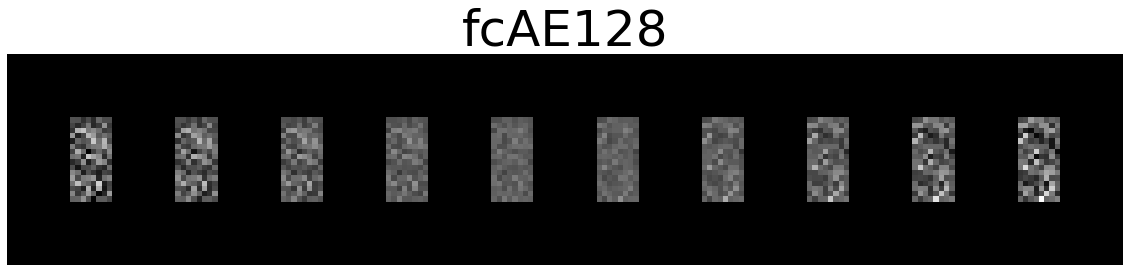

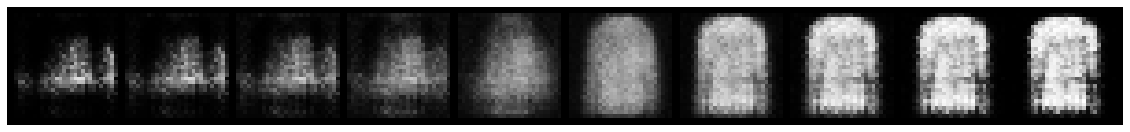

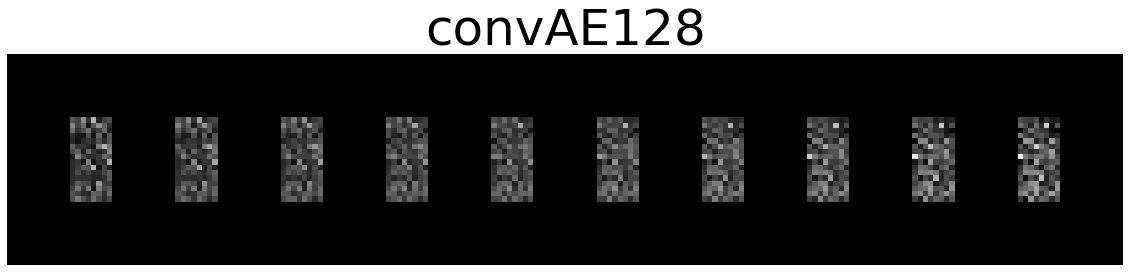

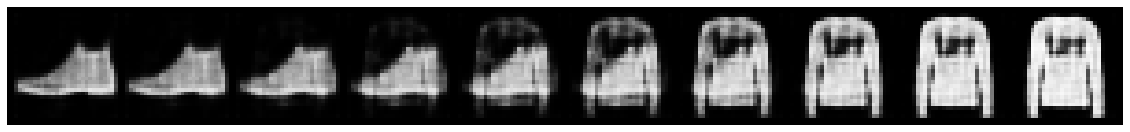

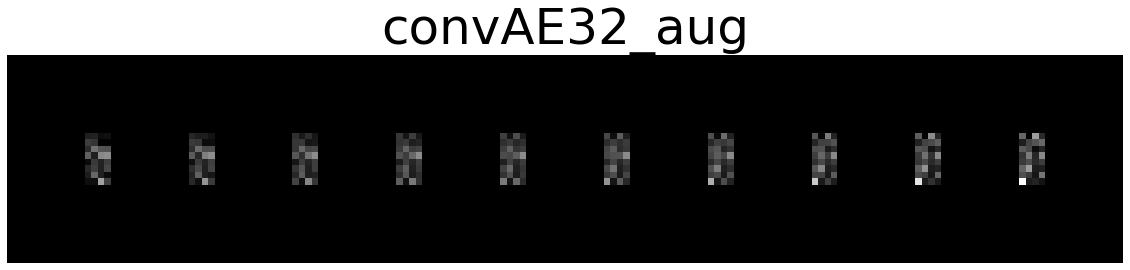

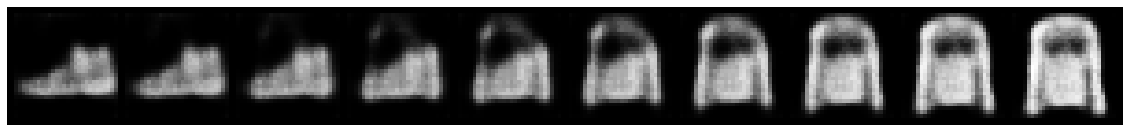

In [262]:

y = x[1] - x[0]
lis = []
m = 10
for i in range(m):
    g = x[0]+(y*i)/(m-1)
    lis.append(g)

lis2 = x[:2]
lis2 = lis2.reshape(2,1,height,width)

plt.figure(figsize = (20,20))
plt.axis("off")
plt.imshow(np.transpose(
    vutils.make_grid(lis, nrow = 10, normalize = True).cpu(),
    (1, 2, 0)))


for key in allModels:
    flag, n, model = allModels[key]
    x_in = lis2
    if(flag):
        x_in = x_in.view(-1, input_size)
    encoded = model.encoder(x_in)

    if(n == 16):
        len1,len2 = 4,4
    elif(n == 32):
        len1,len2 = 8,4
    else:
        len1,len2 = 16,8
    y_latent = encoded[1] - encoded[0]
    lis_encoded = []
    for i in range(m):
        g = encoded[0]+(y_latent*i)/(m-1)
        lis_encoded.append(g)
    encoded = torch.concat(lis_encoded)
    if(flag):
        encoded = encoded.reshape(10,n)
    else:
        encoded = encoded.reshape(10,n,1,1)
    sample = encoded.reshape(10,1,len1,len2)
    decoded = model.decoder(encoded)
    if(flag):
        decoded = decoded.view(-1, 1, width, height)


    plt.figure(figsize = (20,5))
    plt.title(key, fontdict = {'fontsize' : 50})
    plt.axis("off")
    plt.imshow(np.transpose(
        vutils.make_grid(sample, nrow = 10,padding = 12, normalize = True).cpu(),
        (1, 2, 0)))

    plt.figure(figsize = (20,20))

    plt.axis("off")
    plt.imshow(np.transpose(
        vutils.make_grid(decoded, nrow = 10, normalize = True).cpu(),
        (1, 2, 0)))



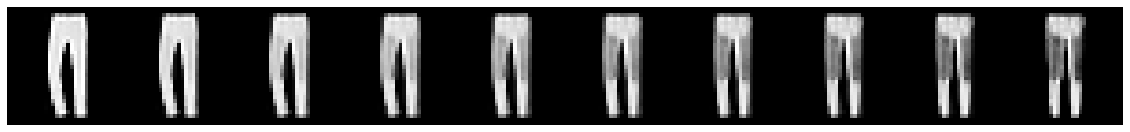

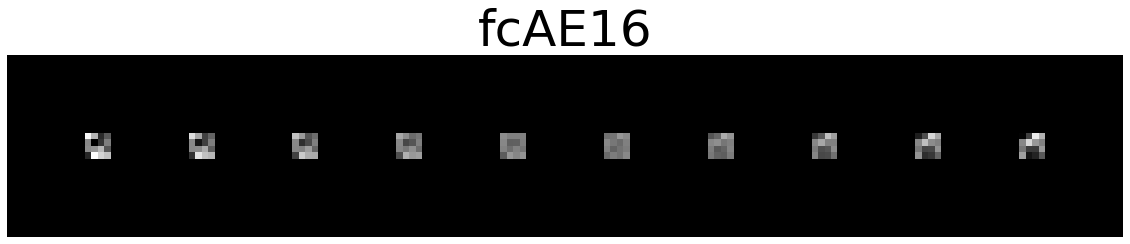

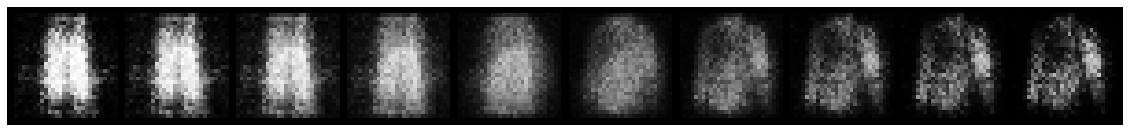

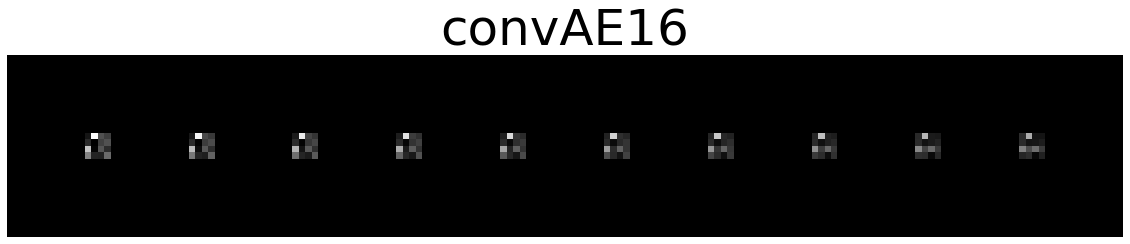

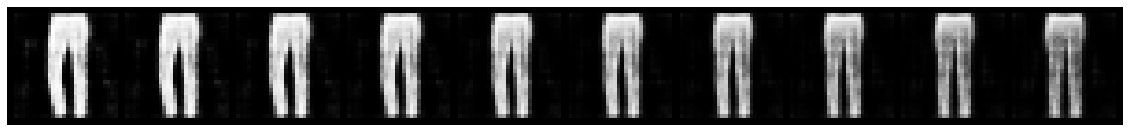

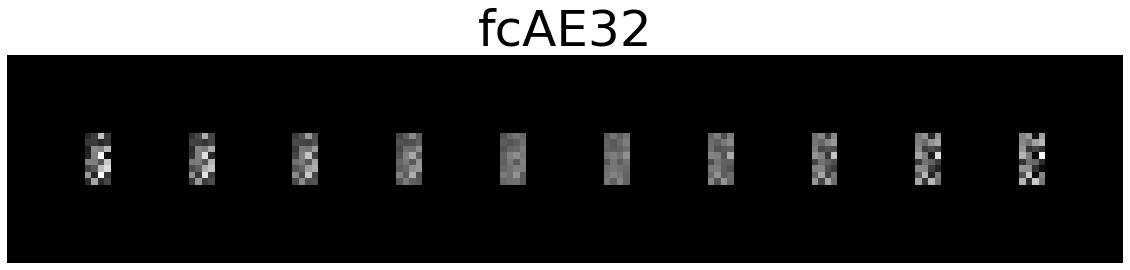

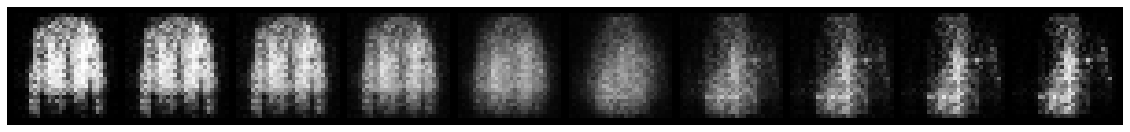

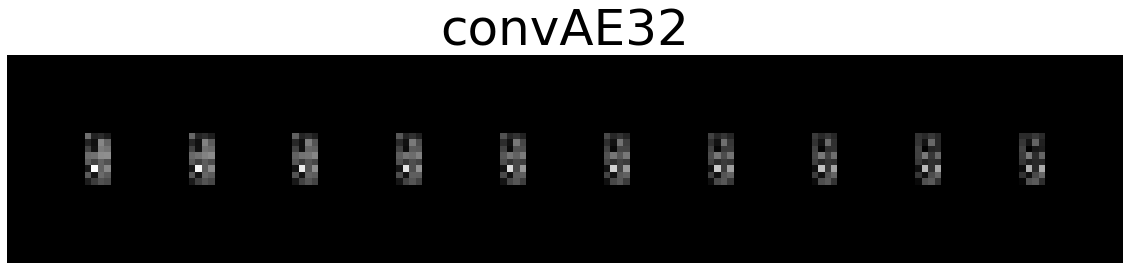

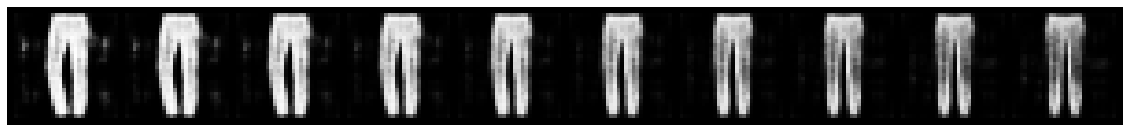

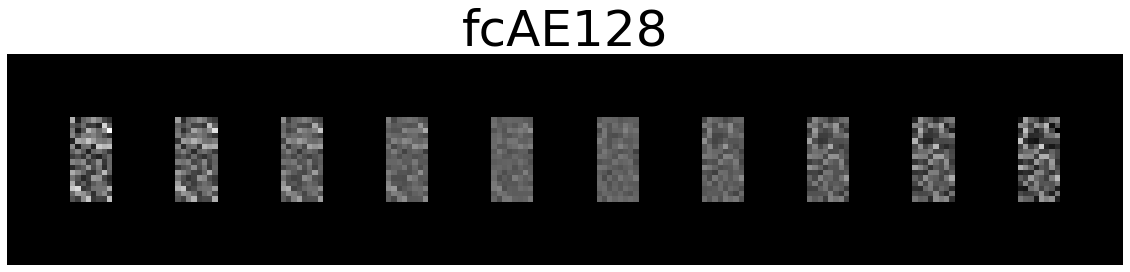

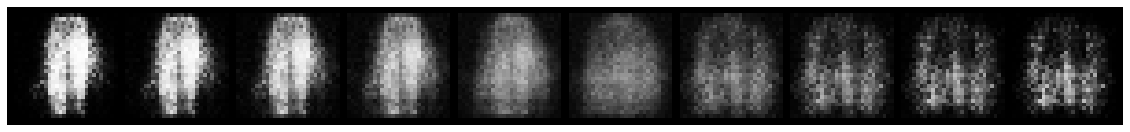

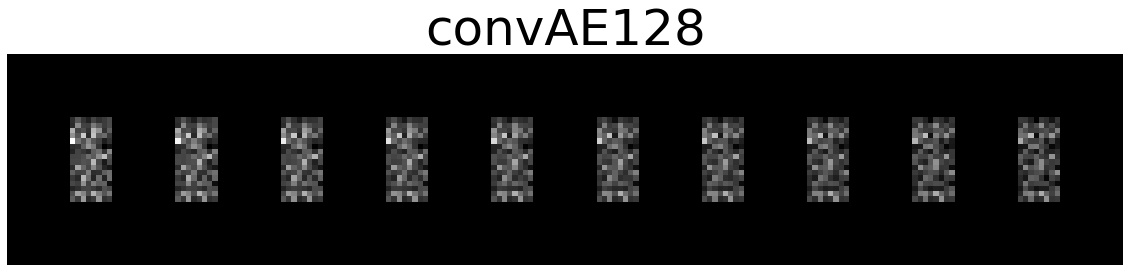

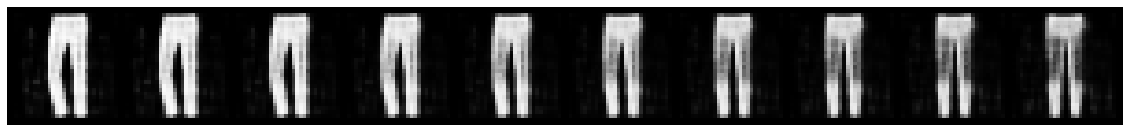

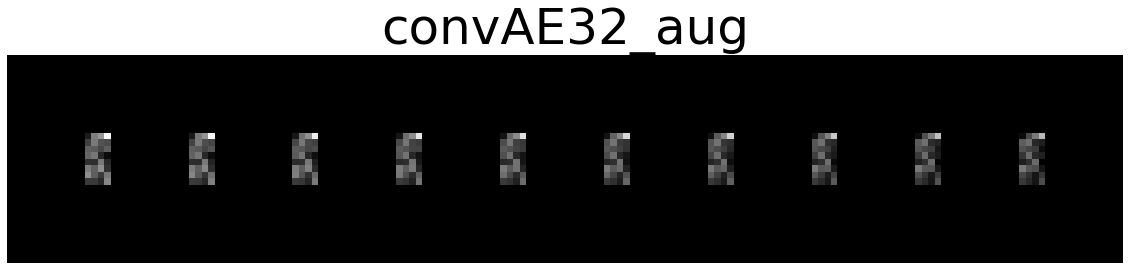

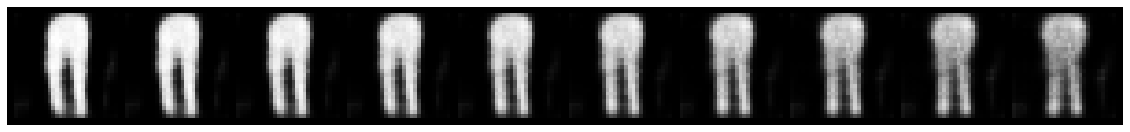

In [263]:
y = x[3] - x[2]
lis = []
m = 10
for i in range(m):
    g = x[2]+(y*i)/(m-1)
    lis.append(g)

lis2 = x[2:4]


plt.figure(figsize = (20,20))
plt.axis("off")
plt.imshow(np.transpose(
    vutils.make_grid(lis, nrow = 10, normalize = True).cpu(),
    (1, 2, 0)))


for key in allModels:
    flag, n, model = allModels[key]
    x_in = lis2
    if(flag):
        x_in = x_in.view(-1, input_size)
    encoded = model.encoder(x_in)

    if(n == 16):
        len1,len2 = 4,4
    elif(n == 32):
        len1,len2 = 8,4
    else:
        len1,len2 = 16,8
    y_latent = encoded[1] - encoded[0]
    lis_encoded = []
    for i in range(m):
        g = encoded[0]+(y_latent*i)/(m-1)
        lis_encoded.append(g)
    encoded = torch.concat(lis_encoded)
    if(flag):
        encoded = encoded.reshape(10,n)
    else:
        encoded = encoded.reshape(10,n,1,1)
    sample = encoded.reshape(10,1,len1,len2)
    decoded = model.decoder(encoded)
    if(flag):
        decoded = decoded.view(-1, 1, width, height)


    plt.figure(figsize = (20,5))
    plt.title(key, fontdict = {'fontsize' : 50})
    plt.axis("off")
    plt.imshow(np.transpose(
        vutils.make_grid(sample, nrow = 10,padding = 12, normalize = True).cpu(),
        (1, 2, 0)))

    plt.figure(figsize = (20,20))

    plt.axis("off")
    plt.imshow(np.transpose(
        vutils.make_grid(decoded, nrow = 10, normalize = True).cpu(),
        (1, 2, 0)))


Answer:(4) Description
* When the two images are similar transformation in way smoother than for very different images
* Also the interpolation in the latent space is more meaningful when it is convolutional rather than fully connected as well as <br>
when latent space dimension is increasing.

---------------------
# 5

a)
n stands for the code-z dimension

For the Fully connected neural network
Layer 1 = 784 - > 256
Layer 2=  256 -> 128
Layer 3=  128 -> n

For the convolutional neural network
Layer 1 = 784 - > 18432
Layer 2=  18432 -> 3200
Layer 3=  3200 -> n


b) Can't tell from the weights alone.For submersion Df should be surjective. Weights alone doesn't give any idea about the differentiability.
c) Can't tell from the weights alone.For immersion Df should be injective. Weights alone doesn't give any idea about the differentiability.


------------------
# 6

In [249]:
def jacobian_calc(model, is_fully_connected , n , images):
    inp = images
    x_inp = inp.reshape(2,1,width,height)
    if(is_fully_connected):
        x_inp = x_inp.view(-1, input_size)
    encoded_val = model.encoder(x_inp)

    decoded_val = model.decoder(encoded_val)
    if(is_fully_connected):
        decoded_val = decoded_val.view(-1, 1, width, height)
    decoded_val = decoded_val[:1]
    decoded_val = decoded_val.reshape(1,height*width)
    deriv = []
    for i in range(n):
        encoded_temp = encoded_val
        if(is_fully_connected):
            encoded_temp[0][i]+= 0.1
        else:
            encoded_temp[0][i][0][0] +=0.1
        decoded_temp = model.decoder(encoded_temp)
        if(is_fully_connected):
            decoded_temp = decoded_temp.view(-1, 1, width, height)
        decoded_temp = decoded_temp[:1]
        decoded_temp = decoded_temp.reshape(1,height*width)
        derivatives = (decoded_temp - decoded_val)/0.1
        deriv.append(derivatives)
    deriv = torch.concat(deriv)
    deriv = deriv.reshape(n,height*width)
    return deriv




In [271]:


def jacobian_calc_new(model, is_fully_connected , n , images):
    inp = images
    x_inp = inp.reshape(2,1,width,height)
    if(is_fully_connected):
        x_inp = x_inp.view(-1, input_size)
    encoded_val = model.encoder(x_inp)
    if(not is_fully_connected):
        encoded_val = encoded_val[:1]
    grad = torch.autograd.functional.jacobian(model.decoder, encoded_val)
    if(is_fully_connected):
        grad = grad[:1,:,:1,:]
    grad = grad.reshape(width*height, n)
    grad = torch.transpose(grad, 0, 1)
    return grad

def jacobian_calc_transposed(model, is_fully_connected , n , images):
    grad = jacobian_calc_new(model, is_fully_connected , n , images)
    grad = torch.transpose(grad, 0, 1)
    return grad

flag, n, model = allModels["fcAE16"]
jacobian_calc_new(model, flag , n , x[:2]).shape


torch.Size([16, 784])

In [272]:
for key in allModels:
    flag, n, model = allModels[key]
    a = jacobian_calc_new(model, flag , n , x[:2])
    u, s, vh = np.linalg.svd(torch.detach(a).numpy(), full_matrices=True)
    print("Model:",key,"     ,Max:",s.max(),"     ,Min:",s.min())


Model: fcAE16      ,Max: 134.54076      ,Min: 2.1666057e-05
Model: convAE16      ,Max: 2.326449      ,Min: 0.00030457767
Model: fcAE32      ,Max: 12.962716      ,Min: 5.9032243e-07
Model: convAE32      ,Max: 2.1215878      ,Min: 0.0003434345
Model: fcAE128      ,Max: 12.828149      ,Min: 5.71667e-08
Model: convAE128      ,Max: 2.6701849      ,Min: 0.00020456873
Model: convAE32_aug      ,Max: 2.5183496      ,Min: 0.00023443282


Answer:
As singular values are positive non-zero values therefore  all Jacobians are full rank.
As all Jacobians are full rank (injective) encoders can be identified as immersions.

-------------------------
# 7


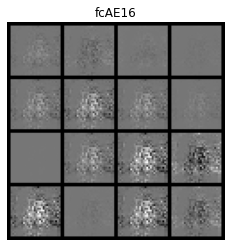

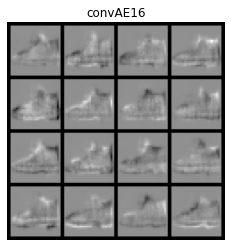

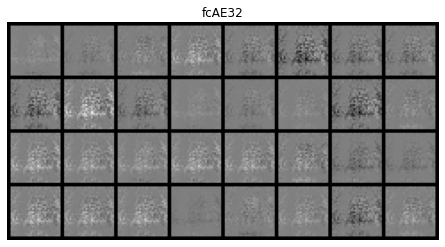

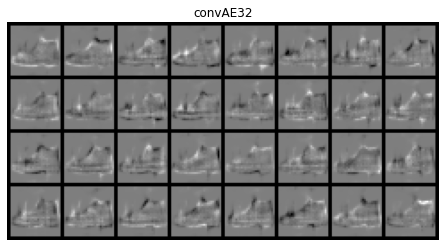

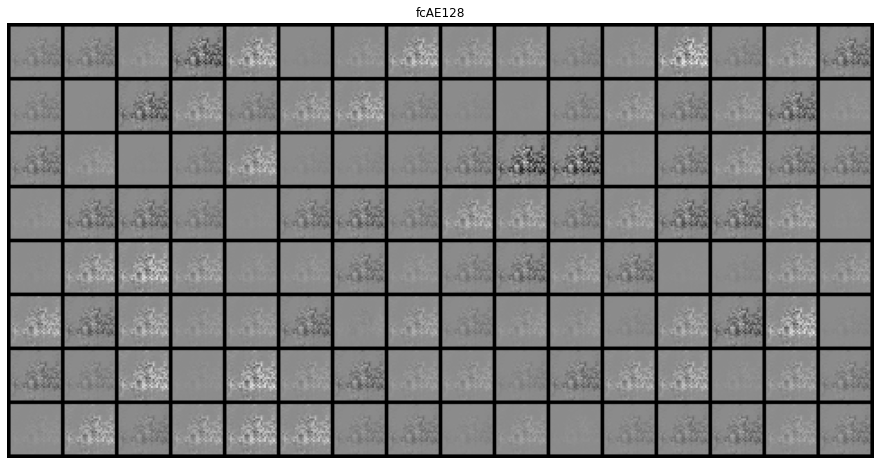

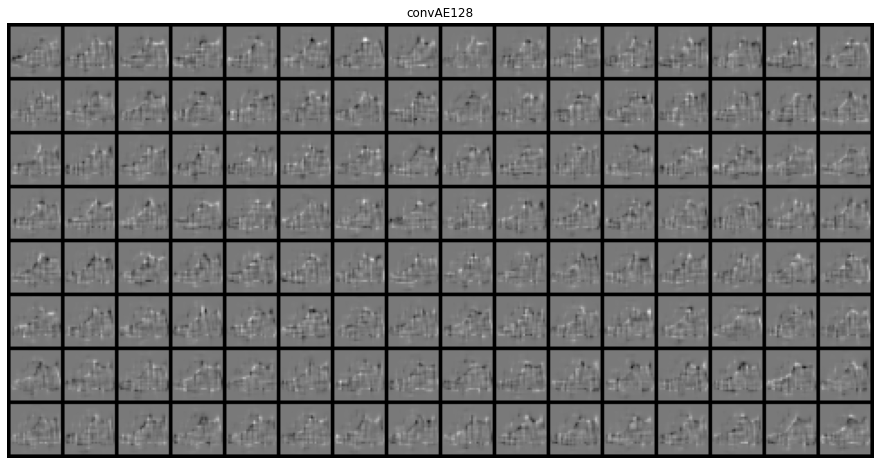

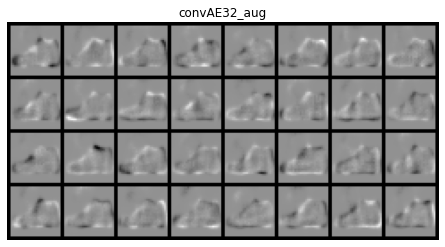

In [273]:
 def plot_Grads(jacob, rows, cols, title = ""):
    plt.figure(figsize = (rows, cols))
    plt.axis("off")
    plt.title(title)
    jacob = jacob.reshape(rows*cols, 1,height, width)
    plt.imshow(np.transpose(
        vutils.make_grid(jacob, nrow = rows, normalize = True).cpu(),
        (1, 2, 0)))

for key in allModels:
    flag, n, model = allModels[key]
    if(n == 16):
        len1,len2 = 4,4
    elif(n == 32):
        len1,len2 = 8,4
    else:
        len1,len2 = 16,8
    a = jacobian_calc_new(model, flag , n , x[:2])
    plot_Grads(a, len1, len2, title = key)

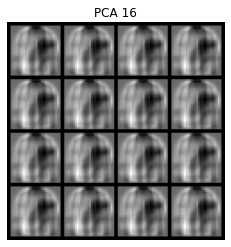

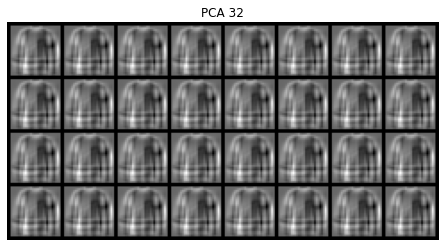

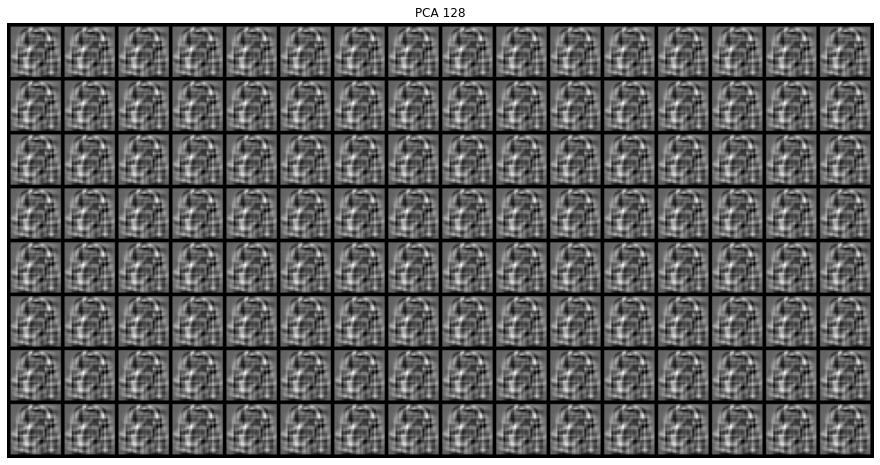

In [274]:

def JacobForPCA(pca,base_image ):

    image_vector = base_image.reshape(1,height*width)

    ##PCA transformation
    trans_image = pca.transform(image_vector)

    ##PCA inverse-transformation
    retrans_image = pca.inverse_transform(trans_image)

    ##making array of n of re-transformed images
    arr1 = np.array([retrans_image[0]]*n)
    arr1 = arr1.reshape(int(key), 1, height*width)
    g= []

    ##Changing the PCA decompositioned values slightly and collecting to  a array
    for i in range(int(key)):
        intermid = trans_image
        intermid[0][i]+=0.1
        g.append(intermid)
    decom_arr = np.array(g)
    retrans_arr = pca.inverse_transform(decom_arr)

    #Calculating the jacobian for PCA
    jacobian = (retrans_arr - arr1)/0.1
    jacobian = torch.from_numpy(jacobian.reshape(n,1,28,28))
    return jacobian







#Iterated over saved PCAs
for key in allPCA:
    n = int(key)
    pca = allPCA[key]
    base_image = x[:1]
    jacobian = JacobForPCA(pca,base_image )
    if(n == 16):
        len1,len2 = 4,4
    elif(n == 32):
        len1,len2 = 8,4
    else:
        len1,len2 = 16,8
    plot_Grads(jacobian, len1, len2, title ="PCA " +key)

Yes, Latent dimension make a sense. Seems it is mapped to different characteristics of the image and by changing the axes those characteristics of the image change.

------------------------------

# 8 and 9

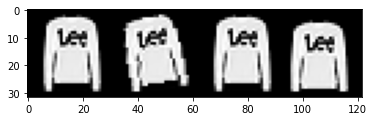

In [275]:
base_image = x[1:2]
rotated = transforms.functional.rotate(base_image,10)
translated_x = transforms.functional.affine(base_image,translate = (2,0), angle = 0, shear = 0,scale =1)
translated_y = transforms.functional.affine(base_image,translate = (0,2), angle = 0, shear = 0,scale =1)
g = [base_image, rotated, translated_x, translated_y]
g = torch.cat(g)
g = g.reshape(4,1,28,28)
plt.imshow(np.transpose(
    vutils.make_grid(g, nrow = 4, normalize = True).cpu(),
    (1, 2, 0)))

In [276]:
def matrixProjection(matrix, vector, not_tensor = False):
    if(not_tensor):
        matrix = matrix.reshape(len(matrix),width*height)
        matrix =  torch.transpose(matrix, 0, 1)
        vector = torch.from_numpy(vector)
        print(matrix.shape, vector.shape)
    vector = vector.reshape(height*width,1)
    matrixT =  torch.transpose(matrix, 0, 1)
    product = torch.matmul(matrixT, matrix)
    inverse = torch.linalg.inv(product)
    val = matmul(matmul(matmul(matrix,inverse), matrixT), vector)
    val =  val.reshape(1,height*width)
    vector =  vector.reshape(1,height*width)
    val = torch.detach(val).numpy()
    val = val.flatten()
    vector = torch.detach(vector).numpy()
    vector = vector.flatten()
    inner = np.inner(vector, val)
    norms = np.linalg.norm(vector) * np.linalg.norm(val)
    cos = inner / norms
    rad = np.arccos(np.clip(cos, -1.0, 1.0))
    deg = np.rad2deg(rad)
    return deg

In [278]:
#Original : 20,-1,-1

base_image = x[0:1]
rotated = transforms.functional.rotate(base_image,20)
translated_x = transforms.functional.affine(base_image,translate = (2,0), angle = 0, shear = 0,scale =1)
translated_y = transforms.functional.affine(base_image,translate = (0,2), angle = 0, shear = 0,scale =1)
g = [base_image, rotated, translated_x, translated_y,base_image]
g = torch.cat(g)
g = g.reshape(5,1,28,28)

rotated = transforms.functional.rotate(base_image,5)
translated_x = transforms.functional.affine(base_image,translate = (0.5,0), angle = 0, shear = 0,scale =1)
translated_y = transforms.functional.affine(base_image,translate = (0,0.5), angle = 0, shear = 0,scale =1)
g_delta = [base_image, rotated, translated_x, translated_y]
g_delta = torch.cat(g_delta)
g_delta = g_delta.reshape(4,1,28,28)
for key in allModels:
    flag, n, model = allModels[key]
    g_forwarded = model.forward(g_delta)
    rotGrad = (g_forwarded[1] - g_forwarded[0])/5
    xGrad = (g_forwarded[2] - g_forwarded[0])/0.5
    yGrad = (g_forwarded[3] - g_forwarded[0])/0.5
    rotJacob = jacobian_calc_transposed(model, flag , n , g[1:3])
    xJacob = jacobian_calc_transposed(model, flag , n , g[2:4])
    yJacob = jacobian_calc_transposed(model, flag , n , g[3:5])
    print("Name of the model  : ", key)
    print("Angle for rotational shift  : "  ,matrixProjection(rotJacob, rotGrad))
    print("Angle for x-axis shift      : "  ,matrixProjection(xJacob, xGrad))
    print("Angle for y-axis shift      : "  ,matrixProjection(yJacob, yGrad))


Name of the model  :  fcAE16
Angle for rotational shift  :  90.67834487882443
Angle for x-axis shift      :  71.49436677429671
Angle for y-axis shift      :  72.42070372260162
Name of the model  :  convAE16
Angle for rotational shift  :  62.05606056476009
Angle for x-axis shift      :  33.682121611076006
Angle for y-axis shift      :  56.57531857421653
Name of the model  :  fcAE32
Angle for rotational shift  :  71.01606032899068
Angle for x-axis shift      :  87.94322482749597
Angle for y-axis shift      :  78.08415678069454
Name of the model  :  convAE32
Angle for rotational shift  :  61.657373574197926
Angle for x-axis shift      :  65.26443712042646
Angle for y-axis shift      :  68.49486761919094
Name of the model  :  fcAE128
Angle for rotational shift  :  91.29206732421868
Angle for x-axis shift      :  83.9714909028177
Angle for y-axis shift      :  89.95912058063745
Name of the model  :  convAE128
Angle for rotational shift  :  47.601118256313136
Angle for x-axis shift      :  5

Answer to 9: When we comparing convAE32, and convAE32_aug, we can see that angles are reduced which mean augmenting data has helped to learn rotation amd translation effectively.

In [201]:

def JacobForPCA(pca,base_image ):

    image_vector = base_image.reshape(1,height*width)

    ##PCA transformation
    trans_image = pca.transform(image_vector)

    ##PCA inverse-transformation
    retrans_image = pca.inverse_transform(trans_image)

    ##making array of n of re-transformed images
    arr1 = np.array([retrans_image[0]]*n)
    arr1 = arr1.reshape(int(key), 1, height*width)
    g= []

    ##Changing the PCA decompositioned values slightly and collecting to  a array
    for i in range(int(key)):
        intermid = trans_image
        intermid[0][i]+=0.1
        g.append(intermid)
    decom_arr = np.array(g)
    retrans_arr = pca.inverse_transform(decom_arr)

    #Calculating the jacobian for PCA
    jacobian = (retrans_arr - arr1)/0.1
    jacobian = torch.from_numpy(jacobian.reshape(n,1,28,28))
    return jacobian





#Iterated over saved PCAs
for key in allPCA:
    key = "32"
    n = int(key)
    pca = allPCA[key]

    image_vector = g_delta.reshape(4,height*width)
    trans_image = pca.transform(image_vector)
    g_forwarded = pca.inverse_transform(trans_image)
    rotGrad = (g_forwarded[1] - g_forwarded[0])/5
    xGrad = (g_forwarded[2] - g_forwarded[0])/0.5
    yGrad = (g_forwarded[3] - g_forwarded[0])/0.5
    rotJacob = JacobForPCA(pca, g[1:2])
    xJacob = JacobForPCA(pca, g[2:3])
    yJacob = JacobForPCA(pca, g[3:4])

    print(key)
    print(matrixProjection(rotJacob, rotGrad,True))
    print(matrixProjection(xJacob, xGrad,True))
    print(matrixProjection(yJacob, yGrad,True))



32
torch.Size([784, 32]) torch.Size([784])


_LinAlgError: torch.linalg.inv: The diagonal element 2 is zero, the inversion could not be completed because the input matrix is singular.